# Volatility Alpha Engine – Notebook 1: Exploratory Data Analysis (EDA)

This notebook performs a full Exploratory Data Analysis (EDA) on underlying assets used by the **Volatility Alpha Engine**.  
It includes:

- Historical price & volume analysis  
- Daily returns  
- Realized volatility (20d & 60d)  
- Correlations  
- Price/Volatility joint trends  
- A quantitative volatility interpretation summary  

This notebook is designed to:

1. Validate the quality of our market data  
2. Understand volatility behavior across time  
3. Identify patterns useful for our ML modeling and Option Screener logic  
4. Provide clean visualizations  


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

plt.style.use("seaborn-v0_8-darkgrid")
pd.options.display.float_format = "{:,.4f}".format

## 1. Load & Inspect Price Data

We begin by importing historical OHLCV data for our chosen ticker(s) using the Polygon or yfinance client.  
This section ensures:

- The data loads correctly  
- Date index is continuous  
- No missing values disrupt volatility calculations  

We will inspect `head()` and `tail()` to visually validate data integrity.

In [2]:
tickers = ["SPY", "QQQ", "TSLA", "NVDA", "AMD"]
tickers

['SPY', 'QQQ', 'TSLA', 'NVDA', 'AMD']

In [3]:
def load_data(symbols, period="6mo"):
    data = {}
    for sym in symbols:
        df = yf.download(sym, period=period, interval="1d")
        df = df[["Close", "Volume"]].dropna() # type: ignore
        data[sym] = df
    return data

data = load_data(tickers)
data["SPY"].head()


/tmp/ipykernel_16772/1984364409.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(sym, period=period, interval="1d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_16772/1984364409.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(sym, period=period, interval="1d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_16772/1984364409.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(sym, period=period, interval="1d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_16772/1984364409.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(sym, period=period, interval="1d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_16772/1984364409.py:4: Future

Price,Close,Volume
Ticker,SPY,SPY
Date,,
2025-05-29,586.6843,69973300
2025-05-30,586.0280,90601200
2025-06-02,589.3291,61630500
2025-06-03,592.6898,63606200
2025-06-04,592.5307,57314200


## 2. Compute Returns & Realized Volatility

To analyze volatility behavior, we calculate:

- **Daily Returns**  
- **Log Returns**  
- **20-Day Realized Volatility (RV20)**  
- **60-Day Realized Volatility (RV60)**  

Realized Volatility is computed using rolling standard deviations of log returns, annualized.  
These features will be essential for both our ML modeling and the Option Screener V1 ranking logic.

In [4]:
# Compute Returns + Realized Volatility (20d & 60d)

def compute_eda(df):
    df = df.copy()

    # Daily returns
    df["Returns"] = df["Close"].pct_change()

    # Log returns
    df["LogRet"] = np.log(df["Close"]).diff()

    # RV20 and RV60 (annualized)
    df["RV20"] = df["LogRet"].rolling(20).std() * np.sqrt(252)
    df["RV60"] = df["LogRet"].rolling(60).std() * np.sqrt(252)

    return df

eda_data = {sym: compute_eda(df) for sym, df in data.items()}

eda_data["SPY"].tail()

Price,Close,Volume,Returns,LogRet,RV20,RV60
Ticker,SPY,SPY,,,,
Date,,,,,,
2025-11-21,659.0300,123956200,0.0100,0.0099,0.1433,0.1220
2025-11-24,668.7300,80437900,0.0147,0.0146,0.1471,0.1247
2025-11-25,675.0200,81077100,0.0094,0.0094,0.1513,0.1248
2025-11-26,679.6800,71879600,0.0069,0.0069,0.1538,0.1251
2025-11-28,683.3900,49212000,0.0055,0.0054,0.1500,0.1245


## 3. Multi-Panel Visualization

This figure gives a high-level overview of:

- Price trend  
- Daily return volatility  
- Short-term (20d) vs long-term (60d) realized volatility  
- Volume trends  

This visual is important for spotting structural volatility shifts and regime changes.

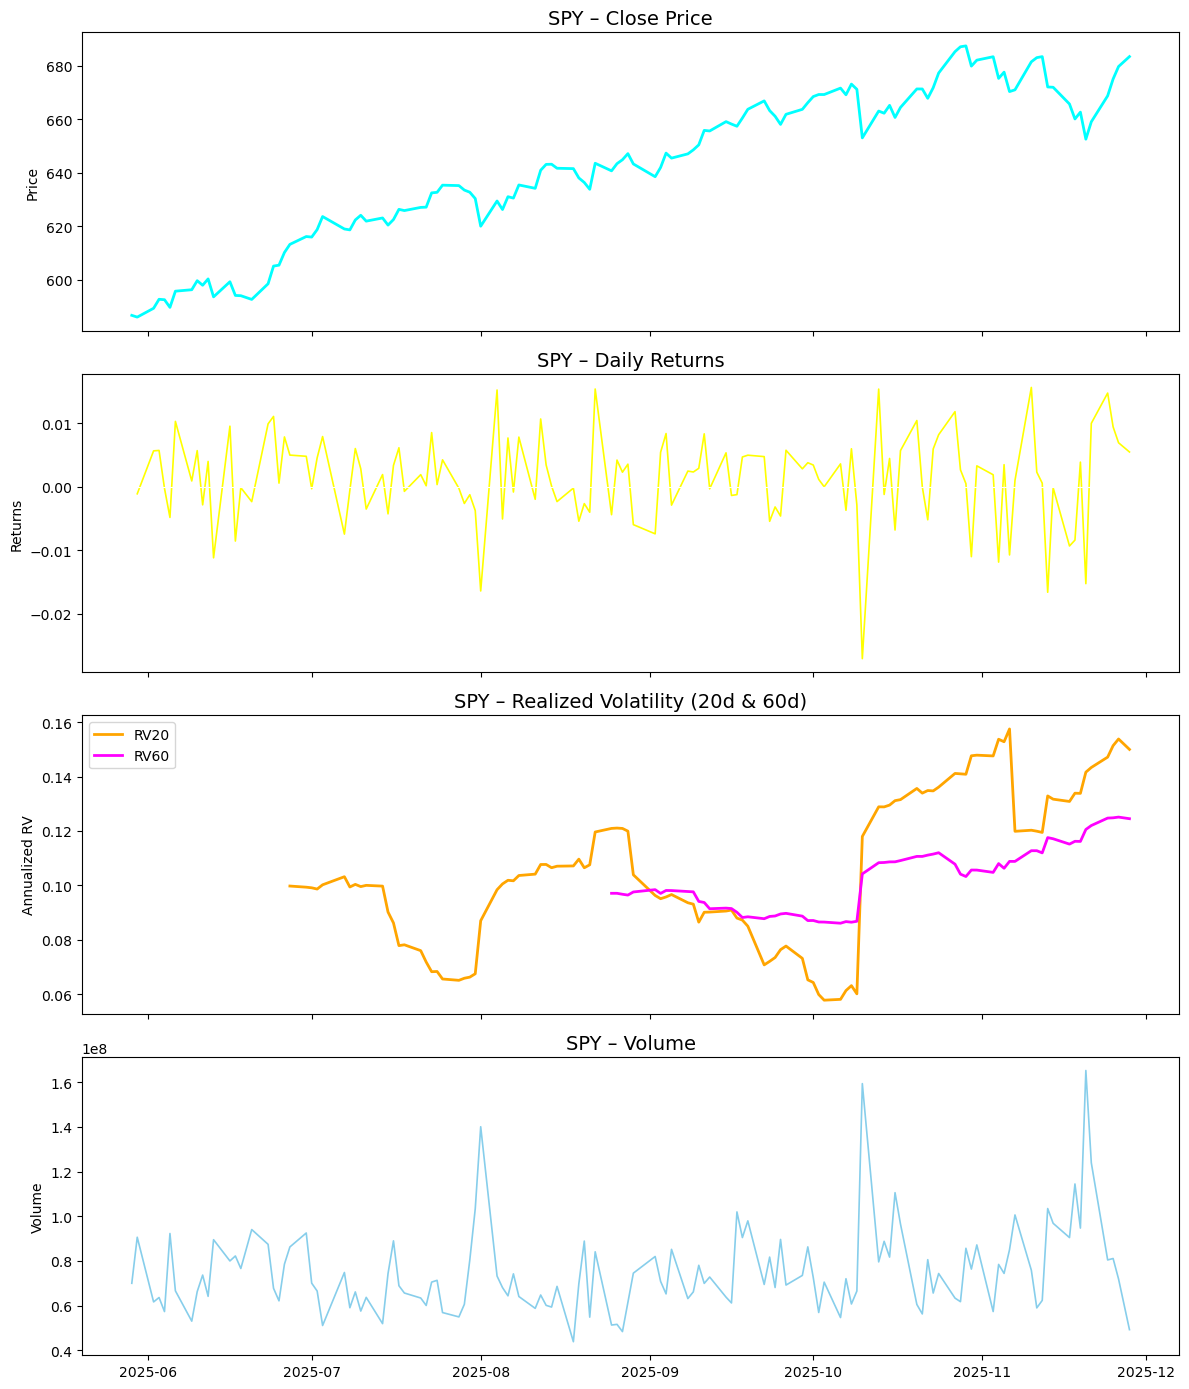

In [5]:
# Price, Returns, RV20/60, and Volume Charts

symbol = "SPY"  # you can change this later for other tickers
df = eda_data[symbol].copy()
df_index = df.index

plt.style.use("default")  # keep things simple & clean

fig, axes = plt.subplots(4, 1, figsize=(12, 14), sharex=True)

# 1. Price trend
axes[0].plot(df_index, df["Close"], color="cyan", linewidth=2) # type: ignore
axes[0].set_title(f"{symbol} – Close Price", fontsize=14) # type: ignore
axes[0].set_ylabel("Price") # type: ignore

# 2. Daily returns
axes[1].plot(df_index, df["Returns"], color="yellow", linewidth=1.2) # type: ignore
axes[1].axhline(0, color="white", linewidth=0.8) # type: ignore
axes[1].set_title(f"{symbol} – Daily Returns", fontsize=14) # type: ignore
axes[1].set_ylabel("Returns") # type: ignore

# 3. Realized Vol (20d vs 60d)
axes[2].plot(df_index, df["RV20"], label="RV20", color="orange", linewidth=2) # type: ignore
axes[2].plot(df_index, df["RV60"], label="RV60", color="magenta", linewidth=2) # type: ignore
axes[2].set_title(f"{symbol} – Realized Volatility (20d & 60d)", fontsize=14) # type: ignore
axes[2].set_ylabel("Annualized RV") # type: ignore
axes[2].legend() # type: ignore

# 4. Volume trend  (switched from bar -> line to avoid the error)
axes[3].plot(df_index, df["Volume"], color="skyblue", linewidth=1.2) # type: ignore
axes[3].set_title(f"{symbol} – Volume", fontsize=14) # type: ignore
axes[3].set_ylabel("Volume") # type: ignore

plt.tight_layout()
plt.show()



## 4. Price vs Realized Volatility (Joint Plot)

Overlaying prices with volatility helps us understand:

- Whether rising prices are accompanied by rising or falling volatility  
- Regime shifts (e.g., volatility spikes during corrections)  
- Divergence patterns between short-term and long-term volatility  

This is one of the most useful views for volatility-based trading strategies.

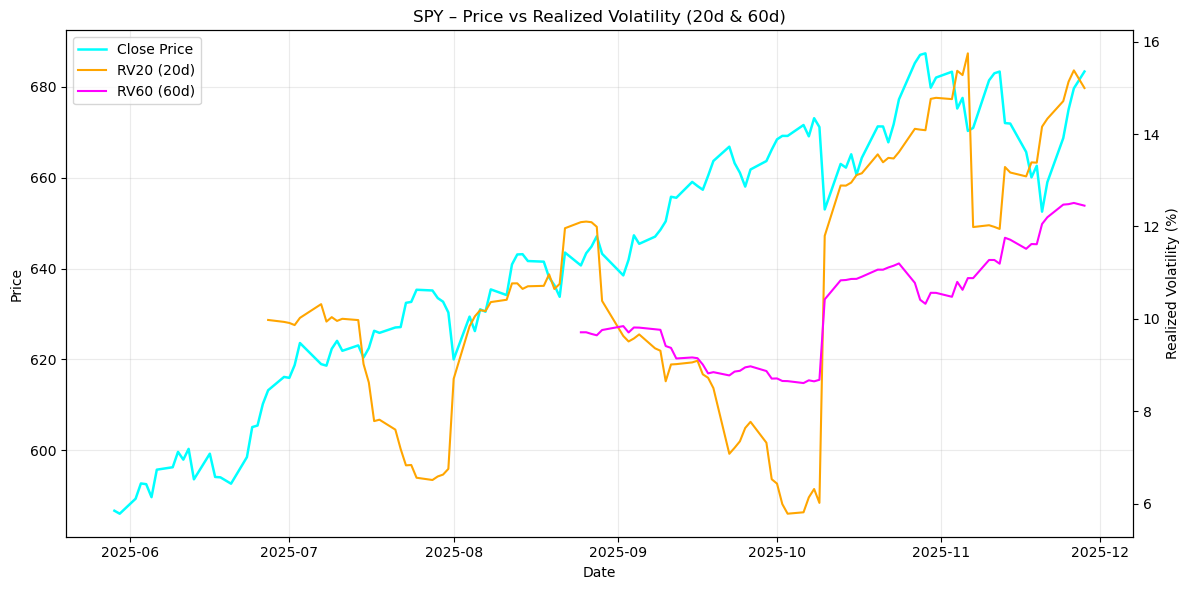

In [6]:
# Price vs Realized Volatility (RV20 & RV60)

# Pick the symbol you want to visualize
symbol = "SPY"  # change to "QQQ", "TSLA", etc. if you add more later

df = eda_data[symbol].copy()

fig, ax_price = plt.subplots(figsize=(12, 6))

# --- Price line (left y-axis) ---
ax_price.plot(
    df.index,
    df["Close"],
    color="cyan",
    linewidth=1.8,
    label="Close Price",
)
ax_price.set_xlabel("Date")
ax_price.set_ylabel("Price")
ax_price.set_title(f"{symbol} – Price vs Realized Volatility (20d & 60d)")

# --- Realized vol lines (right y-axis) ---
ax_rv = ax_price.twinx()
ax_rv.plot( # type: ignore
    df.index,
    df["RV20"] * 100.0,
    color="orange",
    linewidth=1.5,
    label="RV20 (20d)",
)
ax_rv.plot( # type: ignore
    df.index,
    df["RV60"] * 100.0,
    color="magenta",
    linewidth=1.5,
    label="RV60 (60d)",
)
ax_rv.set_ylabel("Realized Volatility (%)")

# --- Combined legend ---
lines_left, labels_left = ax_price.get_legend_handles_labels()
lines_right, labels_right = ax_rv.get_legend_handles_labels() # type: ignore
ax_rv.legend( # type: ignore
    lines_left + lines_right,
    labels_left + labels_right,
    loc="upper left",
)

ax_price.grid(alpha=0.25)
fig.tight_layout()
plt.show()


## 5. Correlation Matrix (Price, Returns, RV20, RV60)

We compute a correlation matrix across:

- Price  
- Returns  
- 20d Volatility  
- 60d Volatility  

This helps us understand how price behavior interacts with different volatility regimes  
and which volatility measures are most predictive or redundant.

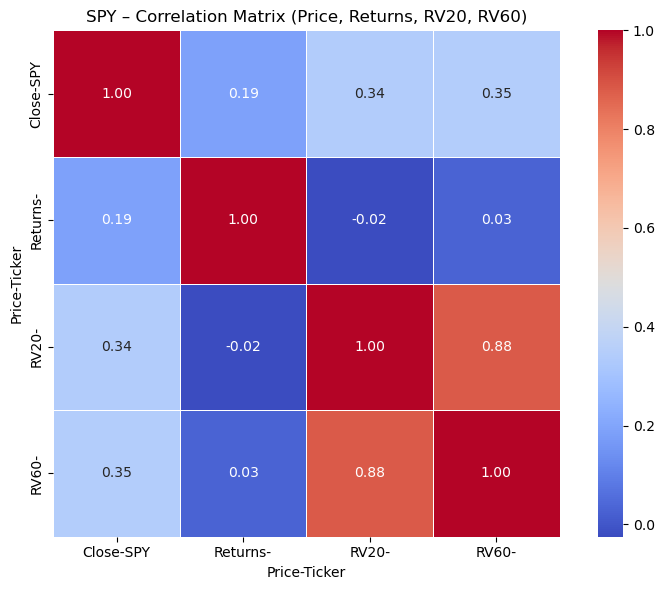

In [7]:
# Correlation Heatmap (Price, Returns, RV20, RV60)

import seaborn as sns

symbol = "SPY"  # modify if needed
df = eda_data[symbol].copy()

# Pick the columns we want to analyze
corr_cols = ["Close", "Returns", "RV20", "RV60"]
corr_df = df[corr_cols].dropna()

corr_matrix = corr_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    square=True,
)
plt.title(f"{symbol} – Correlation Matrix (Price, Returns, RV20, RV60)")
plt.tight_layout()
plt.show()


## 6. Volatility Interpretation Summary

We generate a concise human-readable summary describing:

- Latest price  
- Daily % move  
- Short-term vs long-term volatility  
- What rising/falling RV20 vs RV60 means  
- Market regime indications  

This section is meant for inclusion in the Option Screener V1 UI and weekly trading notes.

In [8]:
import textwrap

symbol = "SPY"
df = eda_data[symbol].dropna()

# Force numeric extraction safely
latest_close = float(df['Close'].iloc[-1])
latest_rv20 = float(df['RV20'].iloc[-1])
latest_rv60 = float(df['RV60'].iloc[-1])
pct_change = float(df['Close'].pct_change().iloc[-1])

trend_label = (
    "Short-term volatility is INCREASING (RV20 > RV60)"
    if latest_rv20 > latest_rv60
    else "Short-term volatility is COOLING (RV20 < RV60)"
)

summary = f"""
Volatility Overview for {symbol}

• Latest Close: ${latest_close:.2f}
• Daily % Change: {pct_change*100:.2f}%
• 20-Day Realized Volatility: {latest_rv20*100:.2f}%
• 60-Day Realized Volatility: {latest_rv60*100:.2f}%

Interpretation:
- {trend_label}
- RV20 vs RV60: Higher RV20 means more recent turbulence.
- RV60 represents the stabilizing long-term volatility trend.
"""

print(textwrap.dedent(summary))



Volatility Overview for SPY

• Latest Close: $683.39
• Daily % Change: 0.55%
• 20-Day Realized Volatility: 15.00%
• 60-Day Realized Volatility: 12.45%

Interpretation:
- Short-term volatility is INCREASING (RV20 > RV60)
- RV20 vs RV60: Higher RV20 means more recent turbulence.
- RV60 represents the stabilizing long-term volatility trend.



/tmp/ipykernel_16772/2767681995.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  latest_close = float(df['Close'].iloc[-1])
/tmp/ipykernel_16772/2767681995.py:10: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pct_change = float(df['Close'].pct_change().iloc[-1])
